# LTH Implementation Conv2 - CIFAR10

In [1]:
# parts from "Conv_2_CIFAR10_Magnitude_based_Pruning_Gaussian_Glorot_initializations", 
# https://github.com/arjun-majumdar/Lottery_Ticket_Hypothesis-TensorFlow_2

### Load packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras
import pickle

from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

%load_ext tensorboard

C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\isabe\Miniconda3\envs\cv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Load and handle CIFAR-10

In [2]:
# save important features of cifar10
num_classes = 10
img_rows, img_cols = 32, 32

In [3]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [4]:
print("Dimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))

Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


# Functions

### Conv-2 architecture

In [5]:
# oriented at https://keras.io/guides/customizing_what_happens_in_fit/, last retrieved 15.12.21
class CustomModel(keras.Sequential):
    
    def train_step(self, data):
        # Unpack the data.
        x, y = data
                        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # List to hold element-wise multiplication between-
        # computed gradient and masks-
        grad_mask_mul = []
        

        # Perform element-wise multiplication between computed gradients and 0, if weight was already
        # 0 before (was pruned, very unlikely that a weight would by chance reach exactly 0!), gradient is 
        # multiplied by 1 else (in order to keep the pruned weights at 0, apply the gradient everywhere else
        for grad_layer, train_vars in zip(gradients, trainable_vars):
            grad_mask_mul.append(tf.math.multiply(grad_layer, tf.math.ceil(tf.math.abs(train_vars))))
    
        # Apply computed gradients to model's weights and biases-
        self.optimizer.apply_gradients(zip(grad_mask_mul, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [6]:
def conv2_cnn(initializer = tf.initializers.GlorotNormal(), custom = False):
    """
    Function to define the architecture of a neural network model
    following Conv-2 architecture for CIFAR-10 dataset and using
    provided parameter which are used to prune the model.

    Conv-2 architecture-
    64, 64, pool  -- convolutions
    256, 256, 10  -- fully connected layers
    
    Inputs:
    'initializer' defines which initializer to use for weights and biases
    'custom' is True if model should follow the custom fit-function and not train weights that are 0

    Output: Returns designed and compiled neural network model
    """
    if custom:
        model = CustomModel()
    else:
        model = Sequential()
    
    # first conv layer
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = initializer,
            bias_initializer = initializer,
            strides = (1, 1), padding = 'same',
            input_shape=(32,32, 3)
            )
    )

    # second conv layer
    model.add(
        Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = initializer,
            bias_initializer = initializer,
            strides = (1, 1), padding = 'same'
            )
    )
    
    # pooling layer
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )

    model.add(Flatten())
    
    # first dense layer
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = initializer,
            bias_initializer = initializer
        )
    )

    # second dense layer
    model.add(
        Dense(
            units = 256, activation='relu',
            kernel_initializer = initializer,
            bias_initializer = initializer
        )
    )

    # third dense layer / output layer
    model.add(
        Dense(
            units = 10, activation='softmax'
        )
    )


    # Compile CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0002),
        metrics=['accuracy']
    )


    return model

### Plot Histories

In [7]:
def plot_histories(his1,name1,his2,name2):
    plt.plot(his1.history["accuracy"], label = "accuracy {0}".format(name1))
    plt.plot(his2.history["accuracy"], label = "accuracy {0}".format(name2))
    plt.plot(his1.history["val_accuracy"], label = "val_accuracy {0}".format(name1))
    plt.plot(his2.history["val_accuracy"], label = "val_accuracy {0}".format(name2))
    plt.legend()
    plt.title("Accuracy")
    plt.show()


    plt.plot(his1.history["loss"], label = "loss {0}".format(name1))
    plt.plot(his2.history["loss"], label = "loss {0}".format(name2))
    plt.plot(his1.history["val_loss"], label = "val_loss {0}".format(name1))
    plt.plot(his2.history["val_loss"], label = "val_loss {0}".format(name2))
    plt.legend()
    plt.title("Loss")
    plt.show()

### prune conv-2 model

In [8]:
# from arjun, changed to give back model and not give back pruned weights in list

def prune_conv2(model, pruning_params_conv, pruning_params_fc, pruning_params_op):
    '''
    Function to prune top p% of trained weights using the provided parameters using
    magnitude-based weight pruning.
    
    Inputs:
    'model' is the TensorFlow 2.0 defined convolutional neural network
    'pruning_params_conv' is the percentage of weights to prune for convolutional layer
    'pruning_params_fc' is the percentage of weights to prune for dense, fully-connected layer
    'pruning_params_op' is the percentage of weights to prune for output layer

    Returns:
    pruned_model 
    '''

    ### initialize new model with 0 everywhere that's going to get changed
    pruned_model = conv2_cnn("zeros", custom = True)  

    for layer_old, layer_pruned in zip(model.layers, pruned_model.layers):   
        
        # if max_pooling or flatten
        if layer_old.get_weights() == []:
            continue
        
        # if convolutional layer
        if len(layer_old.get_weights()[0].shape) == 4:
            
            #print("conv layer: {0}, pruning rate = {1}%".format(layer_old.get_weights()[0].shape, pruning_params_conv))
            
            # shape of w is (height, width, channels, tensors), shape of b is (tensors)
            w = layer_old.get_weights()[0]
            b = layer_old.get_weights()[1] # doesn't need to be changed
            
            # Compute absolute value of 'w'
            w_abs = np.abs(w)

            # Mask values to zero which are less than 'p' in terms of magnitude
            w_abs[w_abs < np.percentile(w_abs, pruning_params_conv)] = 0

            # Where 'w_abs' equals 0, keep 0, else, replace with values of 'w'
            w_new = np.where(w_abs == 0, 0, w)
    
            layer_pruned.set_weights([w_new,b])

        # if fully-connected dense layer
        elif len(layer_old.get_weights()[0].shape) == 2 and layer_old.get_weights()[0].shape[1] != 10:

            #print("dense layer: {0}, pruning rate = {1}%".format(layer_old.get_weights()[0].shape, pruning_params_fc))
            
            # shape of w is (incoming_image_pixels, neurons), shape of b is (neurons)
            w = layer_old.get_weights()[0]
            b = layer_old.get_weights()[1] # doesn't need to be changed

            # Compute absolute value of 'w'
            w_abs = np.abs(w)

            # Mask values to zero which are less than 'p' in terms of magnitude
            w_abs[w_abs < np.percentile(w_abs, pruning_params_fc)] = 0

            # Where 'w_abs' equals 0, keep 0, else, replace with values of 'w'
            w_new = np.where(w_abs == 0, 0, w)

            layer_pruned.set_weights([w_new,b])
        
        # if output layer
        elif len(layer_old.get_weights()[0].shape) == 2 and layer_old.get_weights()[0].shape[1] == 10:

            #print("op layer: {0}, pruning rate = {1}%".format(layer_old.get_weights()[0].shape, pruning_params_op))

            # shape of w is (incoming_image_pixels, neurons), shape of b is (neurons)
            w = layer_old.get_weights()[0]
            b = layer_old.get_weights()[1] # doesn't need to be changed

            # Compute absolute value of 'w'
            w_abs = np.abs(w)

            # Mask values to zero which are less than 'p' in terms of magnitude
            w_abs[w_abs < np.percentile(w_abs, pruning_params_fc)] = 0

            # Where 'w_abs' equals 0, keep 0, else, replace with values of 'w'
            w_new = np.where(w_abs == 0, 0, w)

            layer_pruned.set_weights([w_new,b])


    return pruned_model

## Set IM-Pruning params

In [1]:
###################### set final pruning rate here !! ###########################################
final_percentage_weights = 0.1  # at most 10% of weights should be left

# number of convolutional parameters
conv1 = 1792
conv2 = 36928

# number of fully-connected dense parameters
dense1 = 4194560
dense2 = 65792
op_layer = 2570


# total number of parameters
total_params = conv1 + conv2 + dense1 + dense2 + op_layer

final_pruned_params = final_percentage_weights * total_params 

# Lists to hold percentage of weights pruned in each round for all layers in CNN
conv_pruning = []
dense_pruning = []
op_layer_pruning = []

In [2]:
# count necessary rounds of pruning 
n = 0

# save momentary percentage of pruned params after n rounds
loc_tot_params = total_params
loc_conv1 = conv1
loc_conv2 = conv2
loc_dense1 = dense1
loc_dense2 = dense2
loc_op_layer = op_layer

# save pruned percentages for each round until goal is reached
while loc_tot_params >= final_pruned_params:
    loc_conv1 *= 0.9    # 10% weights are pruned each round
    loc_conv2 *= 0.9    # 10% weights are pruned
    loc_dense1 *= 0.8   # 20% weights are pruned
    loc_dense2 *= 0.8   # 20% weights are pruned
    loc_op_layer *= 0.9 # 10% weights are pruned
    
    conv_pruning.append(((conv1 - loc_conv1) / conv1) * 100)
    dense_pruning.append(((dense1 - loc_dense1) / dense1) * 100)
    op_layer_pruning.append(((op_layer - loc_op_layer) / op_layer) * 100)

    loc_tot_params = loc_conv1 + loc_conv2 + loc_dense1 + loc_dense2 + loc_op_layer

    n += 1

In [11]:
# Convert from list to np.array and round
conv_pruning = np.round(np.array(conv_pruning),3)
dense_pruning = np.round(np.array(dense_pruning),3)
op_layer_pruning = np.round(np.array(op_layer_pruning),3)

In [3]:
# sanity-check
conv_pruning

[10.000000000000002,
 19.0,
 27.1,
 34.39,
 40.95100000000001,
 46.8559,
 52.17031,
 56.953279,
 61.2579511,
 65.13215599,
 68.618940391]

# Iterative Magnitude Pruning

### other functions

In [13]:
# for each round of training before pruning, add history section to whole history
def add_section_to_his(his_whole, his_section):
    his_whole.history["accuracy"] += his_section.history["accuracy"]
    his_whole.history["val_accuracy"] += his_section.history["val_accuracy"]
    his_whole.history["loss"] += his_section.history["loss"]
    his_whole.history["val_loss"] += his_section.history["val_loss"]
    return his_whole

In [15]:
# for both WT and original network, train for some epochs and save history to be able to compare 
# their performance later on
def compare_WT_to_orig(WT, orig_model, nr):
    # how many epochs they should train 
    # (about 40 to match the 6000 iterations of Frankle/Carbin, but 10 are enough)
    epochs = 10
    batch_size = 60

    his_WT = WT.fit(
        X_train,
        y_train, 
        epochs=epochs,
        validation_split=0.1,
        verbose = 0,
        batch_size = batch_size
        )
    
    his_orig = orig_model.fit(
        X_train, 
        y_train, 
        epochs=epochs,
        validation_split=0.1,
        verbose = 0,
        batch_size = batch_size
    )
    
    # save histories
    with open('../tickets/WTs_CIFAR/his_WT_s0.1_nr' + str(nr), 'wb') as file_pi:
        pickle.dump(his_WT.history, file_pi)
        
    with open('../tickets/WTs_CIFAR/his_orig_s0.1_nr' + str(nr), 'wb') as file_pi:
        pickle.dump(his_orig.history, file_pi)
        
    # plot to check result visually
    plot_histories(his_WT, "WT", his_orig, "Orig")
    
    # use early stopping criterion from Frankle/Carbin: Minimum val_loss iteration.
    # only print results here, check later on when actually using the tickets
    print("WT has min in epoch", np.argmin(his_WT.history["val_loss"])+1, "with val_loss", np.min(his_WT.history["val_loss"]))
          
    print("Orig_model has min in epoch", np.argmin(his_orig.history["val_loss"])+1, "with val_loss", np.min(his_orig.history["val_loss"]))
          

### IMP

Starting nr  0
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


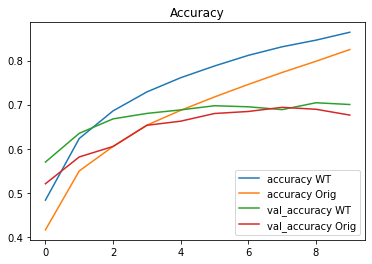

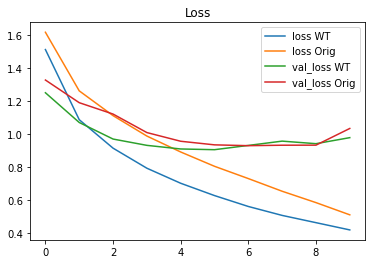

WT has min in epoch 6 with val_loss 0.9050600528717041
Orig_model has min in epoch 7 with val_loss 0.9294337034225464
Starting nr  1
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


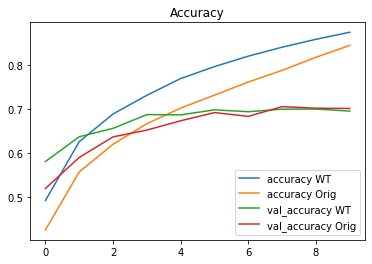

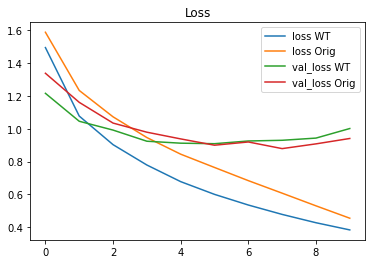

WT has min in epoch 6 with val_loss 0.9087381958961487
Orig_model has min in epoch 8 with val_loss 0.8787548542022705
Starting nr  2
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


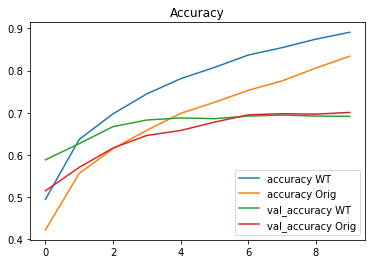

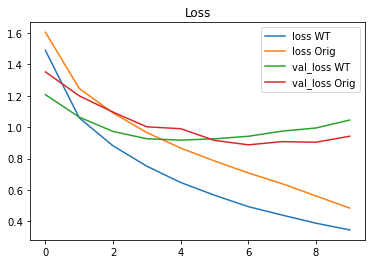

WT has min in epoch 5 with val_loss 0.9171304702758789
Orig_model has min in epoch 7 with val_loss 0.8872631788253784
Starting nr  3
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


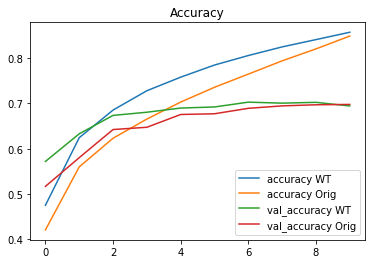

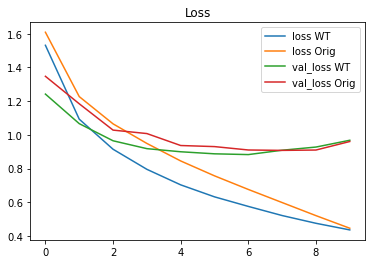

WT has min in epoch 7 with val_loss 0.8830375075340271
Orig_model has min in epoch 8 with val_loss 0.9079458117485046
Starting nr  4
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


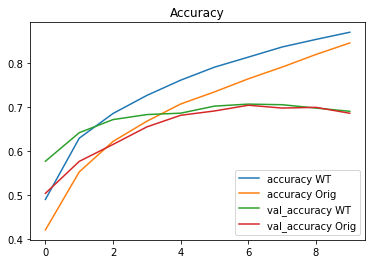

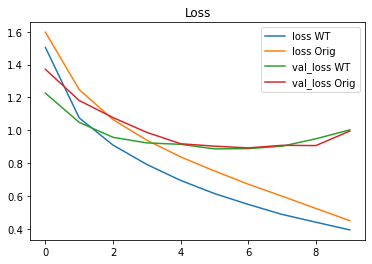

WT has min in epoch 6 with val_loss 0.8867681622505188
Orig_model has min in epoch 7 with val_loss 0.8928158283233643
Starting nr  5
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


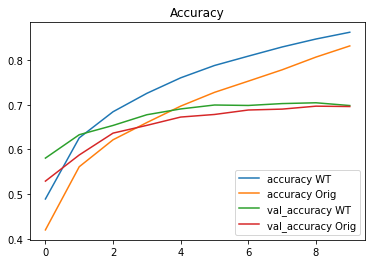

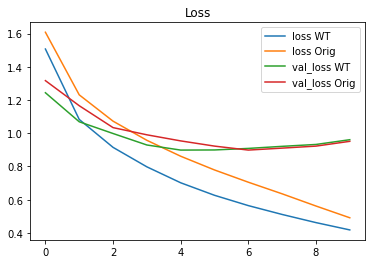

WT has min in epoch 5 with val_loss 0.8983983397483826
Orig_model has min in epoch 7 with val_loss 0.8984206914901733
Starting nr  6
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


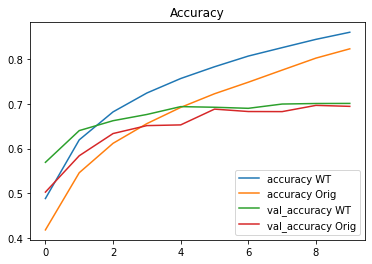

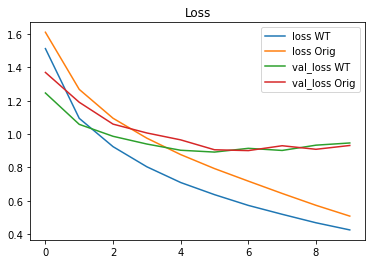

WT has min in epoch 6 with val_loss 0.8919761776924133
Orig_model has min in epoch 7 with val_loss 0.9008391499519348
Starting nr  7
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


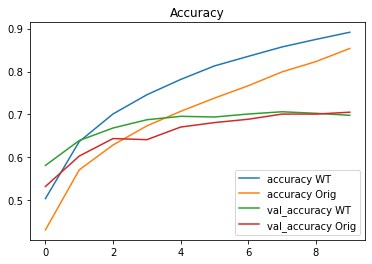

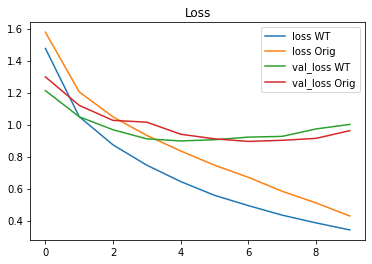

WT has min in epoch 5 with val_loss 0.8976060748100281
Orig_model has min in epoch 7 with val_loss 0.8943797945976257
Starting nr  8
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


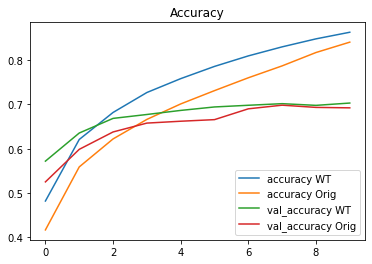

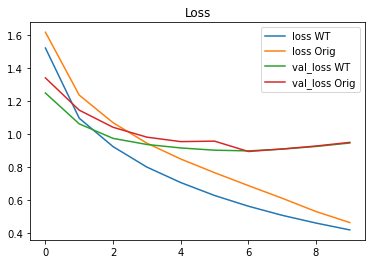

WT has min in epoch 7 with val_loss 0.8993862271308899
Orig_model has min in epoch 7 with val_loss 0.8958021402359009
Starting nr  9
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


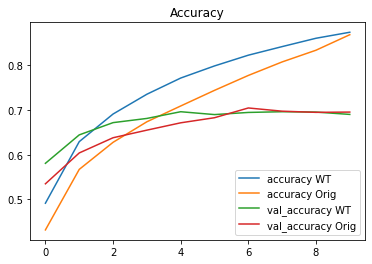

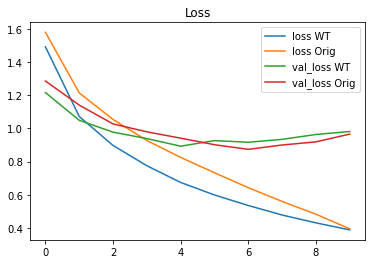

WT has min in epoch 5 with val_loss 0.89287930727005
Orig_model has min in epoch 7 with val_loss 0.8738906979560852
Starting nr  10
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


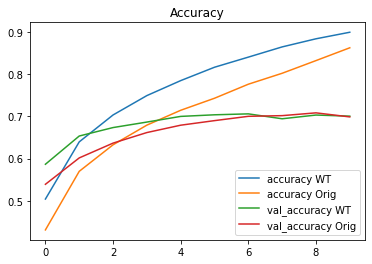

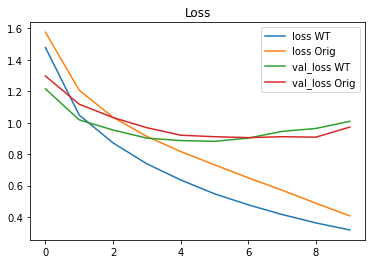

WT has min in epoch 6 with val_loss 0.881470799446106
Orig_model has min in epoch 7 with val_loss 0.9050045609474182
Starting nr  11
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


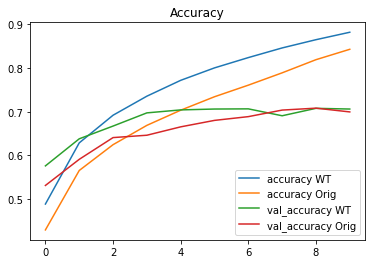

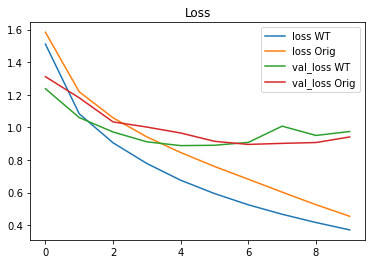

WT has min in epoch 5 with val_loss 0.8881029486656189
Orig_model has min in epoch 7 with val_loss 0.895423173904419
Starting nr  12
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


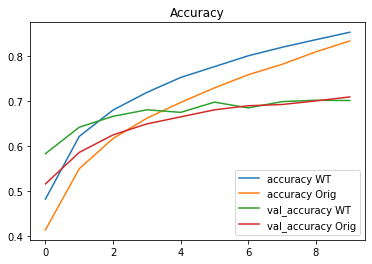

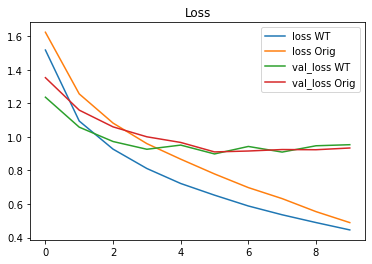

WT has min in epoch 6 with val_loss 0.8980026245117188
Orig_model has min in epoch 6 with val_loss 0.9100661277770996
Starting nr  13
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


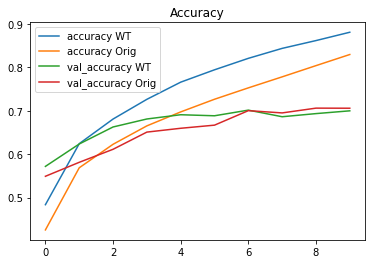

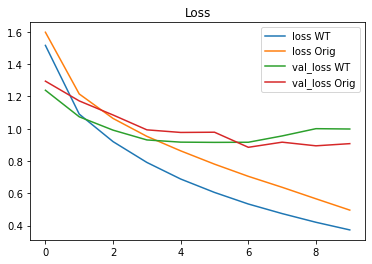

WT has min in epoch 6 with val_loss 0.9151827096939087
Orig_model has min in epoch 7 with val_loss 0.8846660256385803
Starting nr  14
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


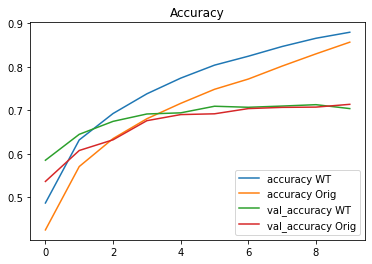

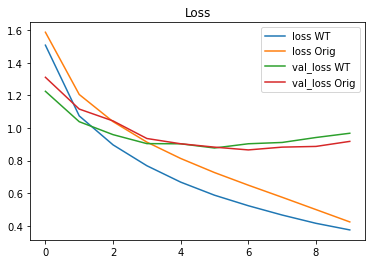

WT has min in epoch 6 with val_loss 0.8770542740821838
Orig_model has min in epoch 7 with val_loss 0.8652085065841675
Starting nr  15
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


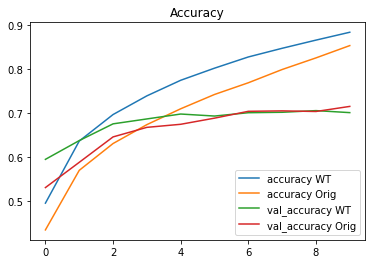

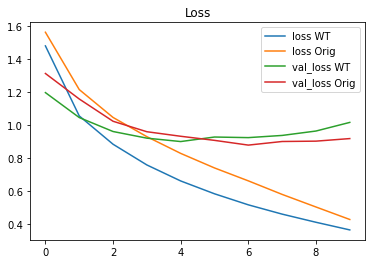

WT has min in epoch 5 with val_loss 0.8996500968933105
Orig_model has min in epoch 7 with val_loss 0.8781113028526306
Starting nr  16
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


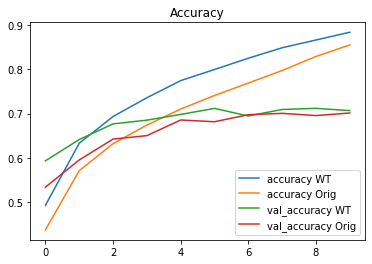

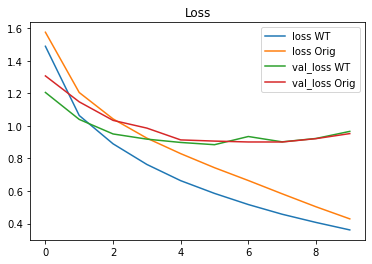

WT has min in epoch 6 with val_loss 0.8845528364181519
Orig_model has min in epoch 8 with val_loss 0.901153028011322
Starting nr  17
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


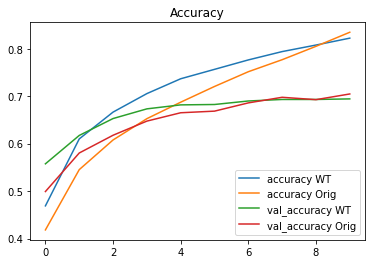

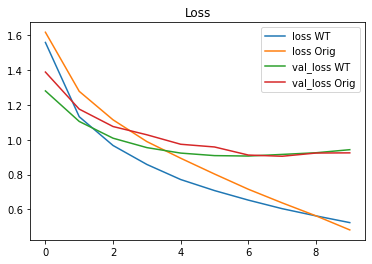

WT has min in epoch 7 with val_loss 0.906258761882782
Orig_model has min in epoch 8 with val_loss 0.9050357341766357
Starting nr  18
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


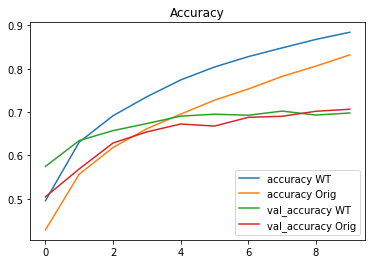

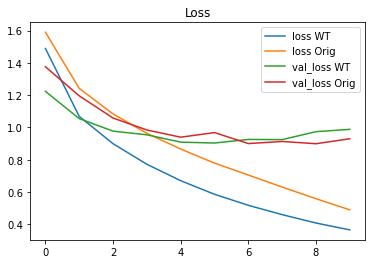

WT has min in epoch 6 with val_loss 0.9031105637550354
Orig_model has min in epoch 9 with val_loss 0.898798942565918
Starting nr  19
pruning round nr  1 / 11
pruning round nr  2 / 11
pruning round nr  3 / 11
pruning round nr  4 / 11
pruning round nr  5 / 11
pruning round nr  6 / 11
pruning round nr  7 / 11
pruning round nr  8 / 11
pruning round nr  9 / 11
pruning round nr  10 / 11
pruning round nr  11 / 11
finished training WT


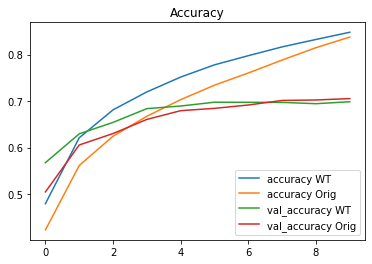

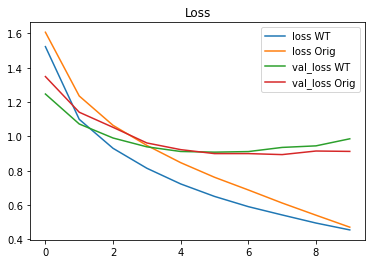

WT has min in epoch 6 with val_loss 0.9078696370124817
Orig_model has min in epoch 8 with val_loss 0.8936169743537903


In [17]:
########### set parameters here ##################
nr_winning_tickets = 20
nr_pruning_rounds = n
nr_epochs_per_round = 8

# for each WT that should be extracted:
for i in range(0, nr_winning_tickets):   
    
    print("Starting nr ", i)
    
    # initiate random network and save it
    orig_model = conv2_cnn()
    # serialize weights to HDF5
    orig_model.save_weights("../tickets/WTs_CIFAR/orig_model_s0.1_nr" + str(i) + ".h5")
        
    # train several steps, prune certain percentage, reinitialize and train again until final percentage achieved
    # initiate model to be trained
    trained_model = conv2_cnn(custom = True)
    trained_model.set_weights(orig_model.get_weights()) 
        
    for j in range(nr_pruning_rounds):
        print("pruning round nr ", j+1, "/", nr_pruning_rounds)
        # train for nr_epochs_per_round steps
        # fit model and save accuracy in history
        history_trained_net_section = trained_model.fit(
            X_train, 
            y_train, 
            epochs=nr_epochs_per_round,
            validation_split=0.1,
            verbose = 0, 
            batch_size = 60
        )
        
        
        # save history if its first round of pruning, add to existing history if not 
        if j == 0:
            history_trained_net = history_trained_net_section
        else:
            history_trained_net = add_section_to_his(history_trained_net, history_trained_net_section)
            
            
        # prune net according to pruning rates for this round
        trained_model = prune_conv2(trained_model, conv_pruning[j], dense_pruning[j], op_layer_pruning[j])
        
        
        # reinitialize pruned net
        for orig_wts, trained_wts in zip(orig_model.trainable_weights, trained_model.trainable_weights):
            trained_wts.assign(tf.where(tf.equal(trained_wts, 0), trained_wts, orig_wts))
            

    # final network is already a canditat for a WT as it was reinitialized, save it
    trained_model.save_weights("../tickets/WTs_CIFAR/WT_s0.1_nr" + str(i) + ".h5")
    
    # save history_trained_net
    with open('../tickets/WTs_CIFAR/his_train_0.1_nr' + str(i), 'wb') as file_pi:
        pickle.dump(history_trained_net.history, file_pi)
    
    # check if WT (save histories to make it possible to check and decide later on)
    compare_WT_to_orig(trained_model, orig_model, nr = i)
    

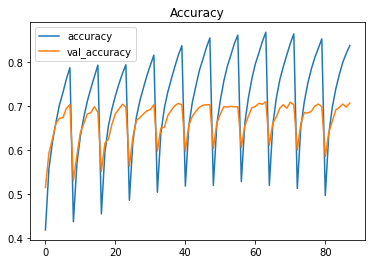

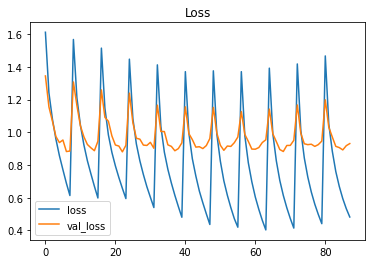

In [18]:
# look at example history while IMP
plot_history(history_trained_net)

## Find Random Tickets

In [20]:
def compare_random_to_orig(random, orig_model, nr):
    # how many epochs they should train 
    #(about 40 to match the 6000 iterations of Frankle/Carbin, but 10 are enough)
    epochs = 10
    batch_size = 60

    his_random = random.fit(
        X_train, 
        y_train, 
        epochs=epochs,
        validation_split=0.1,
        verbose = 0,
        batch_size = batch_size
        )
    
    his_orig = orig_model.fit(
        X_train, 
        y_train, 
        epochs=epochs,
        validation_split=0.1,
        verbose = 0,
        batch_size = batch_size
    )
    
    # save histories
    with open('../tickets/random/his_random_s0.1_nr' + str(nr), 'wb') as file_pi:
        pickle.dump(his_random.history, file_pi)
        
    with open('../tickets/random/his_orig_s0.1_nr' + str(nr), 'wb') as file_pi:
        pickle.dump(his_orig.history, file_pi)
        
    plot_histories(his_random, "random", his_orig, "Orig")
    
    # use early stopping criterion from Frankle/Carbin: Minimum val_loss iteration
    print("random has min in epoch", np.argmin(his_random.history["val_loss"])+1, "with val_loss", np.min(his_random.history["val_loss"]))
          
    print("Orig_model has min in epoch", np.argmin(his_orig.history["val_loss"])+1, "with val_loss", np.min(his_orig.history["val_loss"]))
          

finished training random


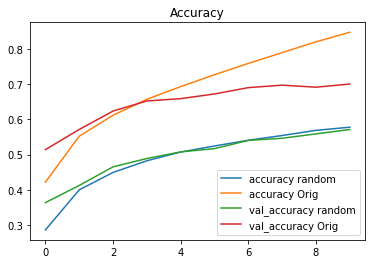

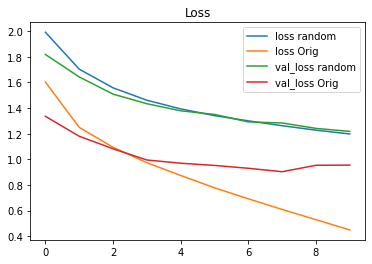

random has min in epoch 10 with val_loss 1.218203067779541
Orig_model has min in epoch 8 with val_loss 0.9035014510154724
finished training random


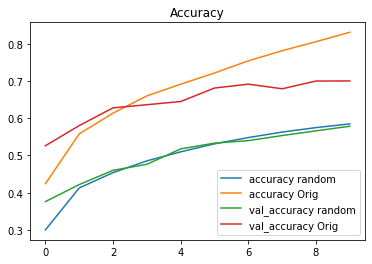

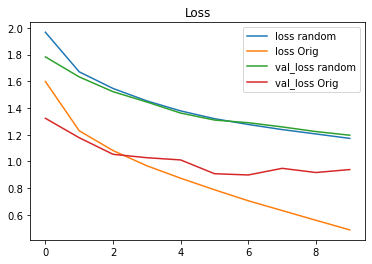

random has min in epoch 10 with val_loss 1.1964725255966187
Orig_model has min in epoch 7 with val_loss 0.8989846706390381
finished training random


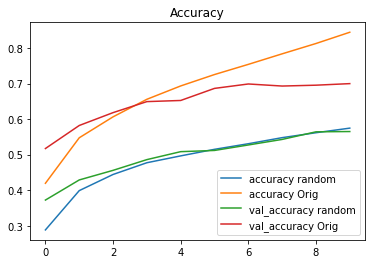

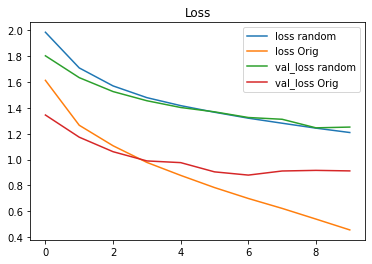

random has min in epoch 9 with val_loss 1.2450206279754639
Orig_model has min in epoch 7 with val_loss 0.8795653581619263
finished training random


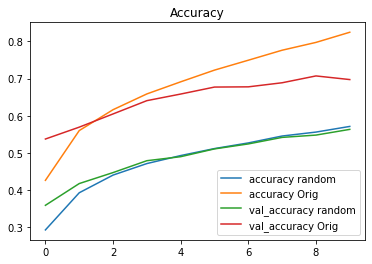

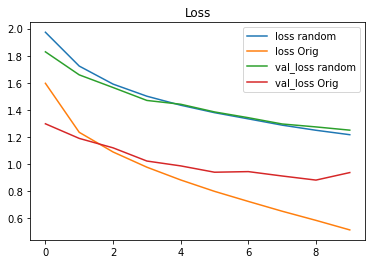

random has min in epoch 10 with val_loss 1.2496248483657837
Orig_model has min in epoch 9 with val_loss 0.880613386631012
finished training random


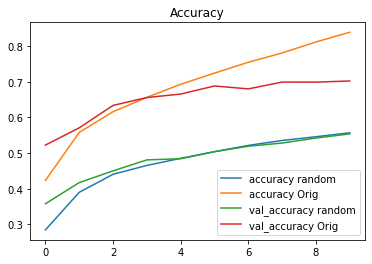

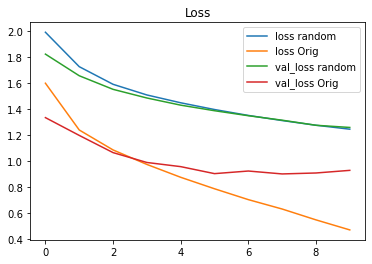

random has min in epoch 10 with val_loss 1.2600836753845215
Orig_model has min in epoch 8 with val_loss 0.9020249843597412
finished training random


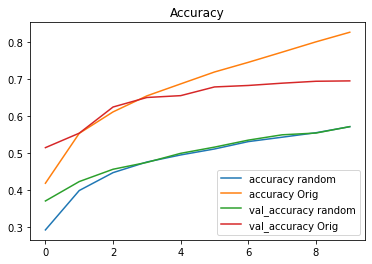

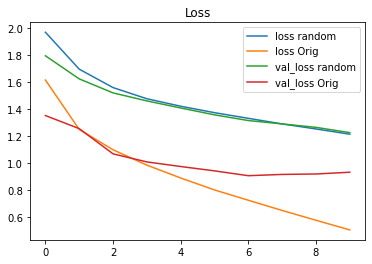

random has min in epoch 10 with val_loss 1.2263153791427612
Orig_model has min in epoch 7 with val_loss 0.907301664352417
finished training random


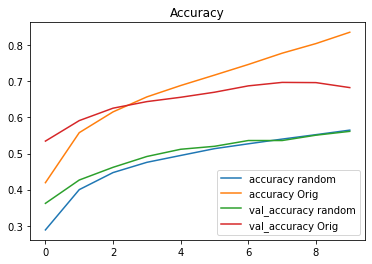

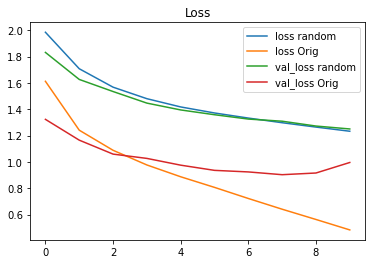

random has min in epoch 10 with val_loss 1.2498630285263062
Orig_model has min in epoch 8 with val_loss 0.9025511741638184
finished training random


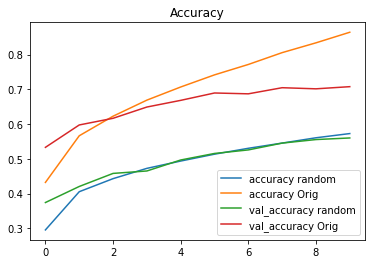

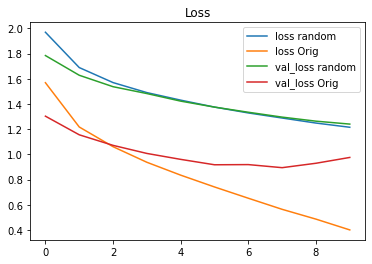

random has min in epoch 10 with val_loss 1.2407490015029907
Orig_model has min in epoch 8 with val_loss 0.894829511642456
finished training random


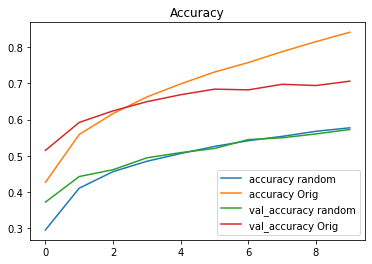

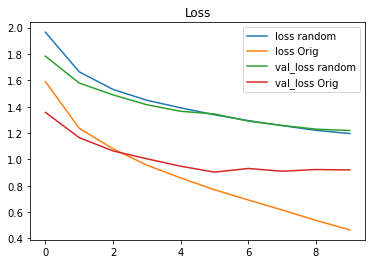

random has min in epoch 10 with val_loss 1.2193212509155273
Orig_model has min in epoch 6 with val_loss 0.9035807847976685
finished training random


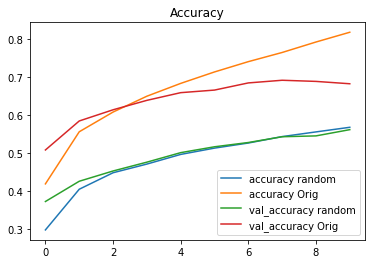

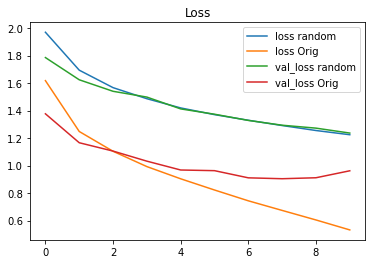

random has min in epoch 10 with val_loss 1.2364860773086548
Orig_model has min in epoch 8 with val_loss 0.9045745134353638
finished training random


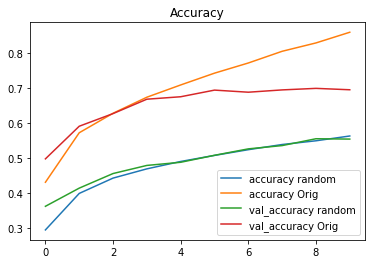

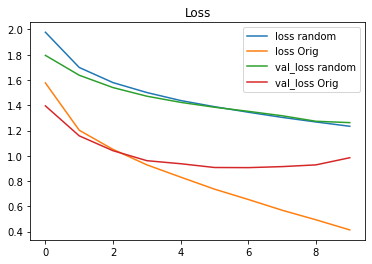

random has min in epoch 10 with val_loss 1.2624669075012207
Orig_model has min in epoch 7 with val_loss 0.9063370823860168
finished training random


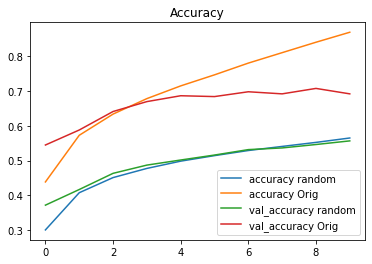

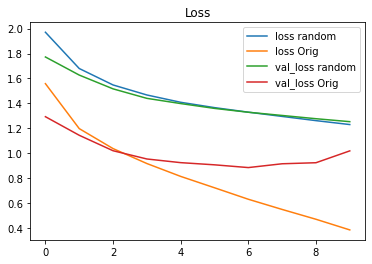

random has min in epoch 10 with val_loss 1.2542052268981934
Orig_model has min in epoch 7 with val_loss 0.8865033984184265
finished training random


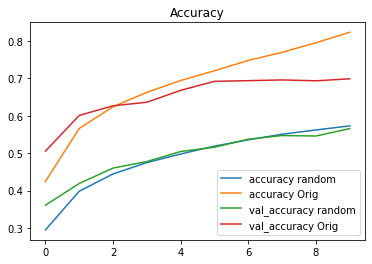

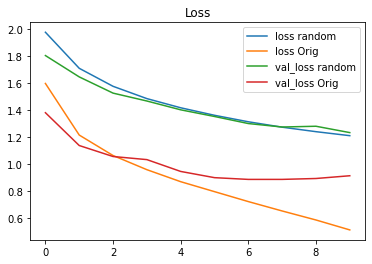

random has min in epoch 10 with val_loss 1.2332676649093628
Orig_model has min in epoch 7 with val_loss 0.8877243399620056
finished training random


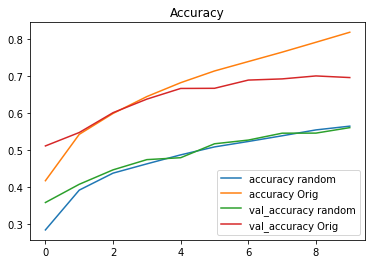

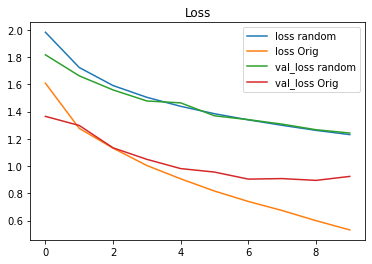

random has min in epoch 10 with val_loss 1.2429006099700928
Orig_model has min in epoch 9 with val_loss 0.8951339721679688
finished training random


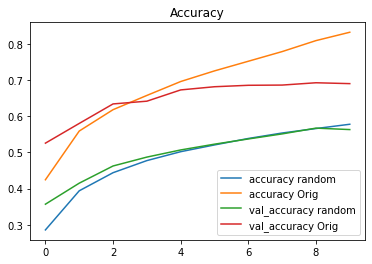

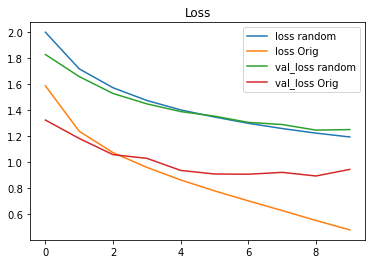

random has min in epoch 9 with val_loss 1.2459876537322998
Orig_model has min in epoch 9 with val_loss 0.8945352435112
finished training random


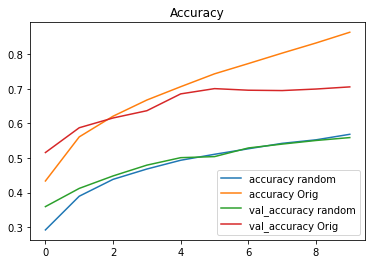

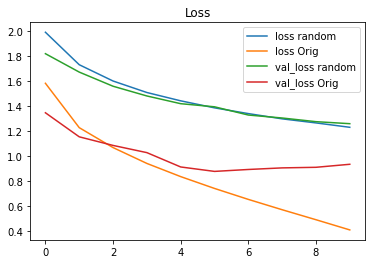

random has min in epoch 10 with val_loss 1.2577040195465088
Orig_model has min in epoch 6 with val_loss 0.8754965662956238
finished training random


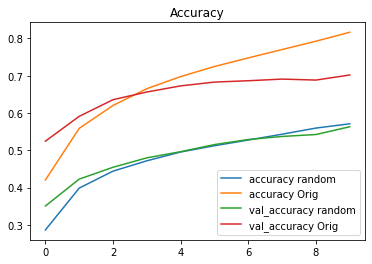

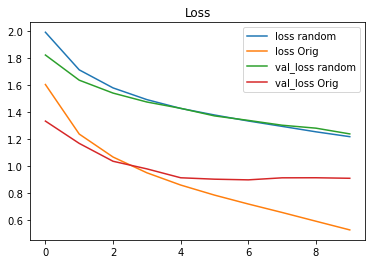

random has min in epoch 10 with val_loss 1.2393065690994263
Orig_model has min in epoch 7 with val_loss 0.8996044993400574
finished training random


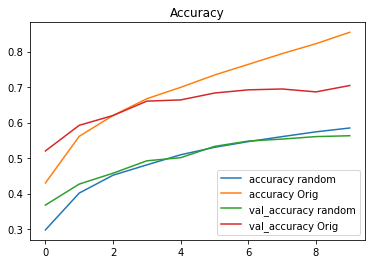

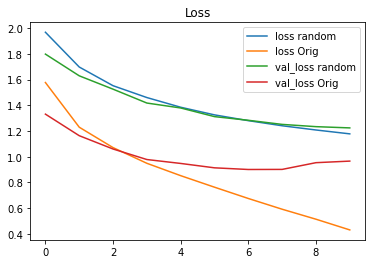

random has min in epoch 10 with val_loss 1.2237157821655273
Orig_model has min in epoch 7 with val_loss 0.900265634059906
finished training random


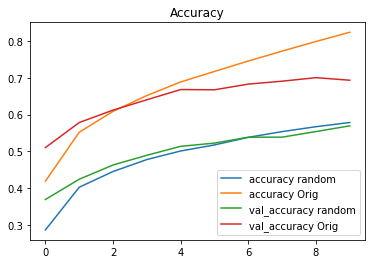

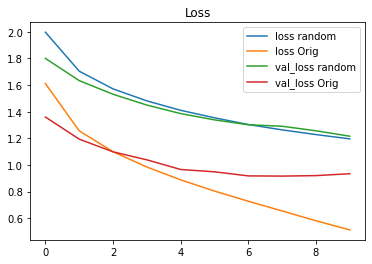

random has min in epoch 10 with val_loss 1.215849757194519
Orig_model has min in epoch 8 with val_loss 0.9164705276489258
finished training random


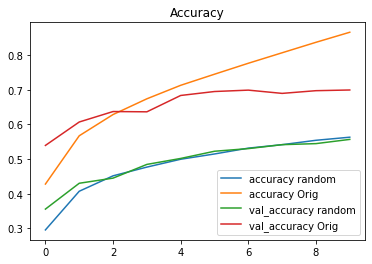

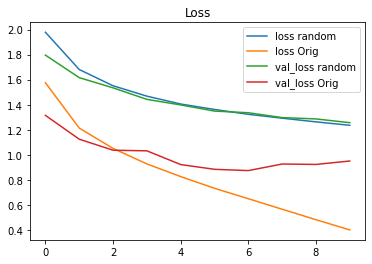

random has min in epoch 10 with val_loss 1.2563410997390747
Orig_model has min in epoch 7 with val_loss 0.873604416847229


In [21]:
nr_random_tickets = 20

# for each random ticket that should be extracted:
for i in range(0, nr_random_tickets):   
    
    # initiate random network and save it
    orig_model = conv2_cnn()
    # serialize weights 
    orig_model.save_weights("../tickets/random/orig_model_s0.1_nr" + str(i) + ".h5")
    
    # copy this network into a custom model
    pruned_model = conv2_cnn(custom = True)
    pruned_model.set_weights(orig_model.get_weights())
              
    # prune custom model 
    pruned_model = prune_conv2(orig_model, conv_pruning[-1], dense_pruning[-1], op_layer_pruning[-1])
         
    # save random ticket
    pruned_model.save_weights("../tickets/random/random_s0.1_nr" + str(i) + ".h5")
    
    # check if not WT (save hists)
    compare_random_to_orig(pruned_model, orig_model, nr = i)